In [64]:
%load_ext autoreload
%autoreload 2
import sys
from tqdm.notebook import tqdm
import scqubits as sq
sys.path.append('..')
filedirectory = "//Users//joancaceres//Documents//FERBO//FB_W10_S4//run2//"
from src.utilities import *
from scipy.optimize import curve_fit
from src.fitting import get_transitions_from_levels, plot_transitions
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Datasets

In [139]:
datasets = {
    'sts_power':        409931,
    'res_fluq':         416866,
    'two_res':          200907,
    'sts_flux':         411703,
    'sts_flux_zoom':    413199,
    'flux_drifting':    421220,
    'sts_power_change': 418329,   
    'sts_power_change2':421479,
    'tts_upper':        422958,
    'tts_lower':        424530,
    'tts_zero':         422231,
    'tts_double':       401277,
    't1':               405783,    
    'ramsey':           421172,
}

In [140]:
data = {}
for key, datanumber in tqdm(datasets.items()):
    data[key] = load_data(filedirectory + "FBW10S4_" +str(datanumber))
    if 'freq' in data[key]:
        data[key]['freq'] *= 1e-9

  0%|          | 0/15 [00:00<?, ?it/s]

# Single tone spectroscopy

## Single tone spectroscopy vs. gain

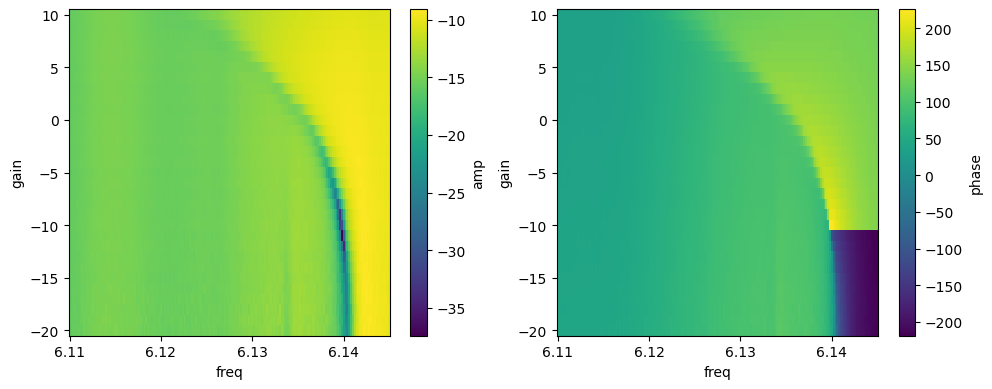

In [102]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
plot3D(
    data_dict=data['sts_power'],
    x_key='freq',
    y_key='gain',
    z_key='amp',
    ax=ax[0],
    fig=fig,
)

plot3D(
    data_dict=data['sts_power'],
    x_key='freq',
    y_key='gain',
    z_key='phase',
    ax=ax[1],
    fig=fig,
    )
plt.show()

### Additional resonance

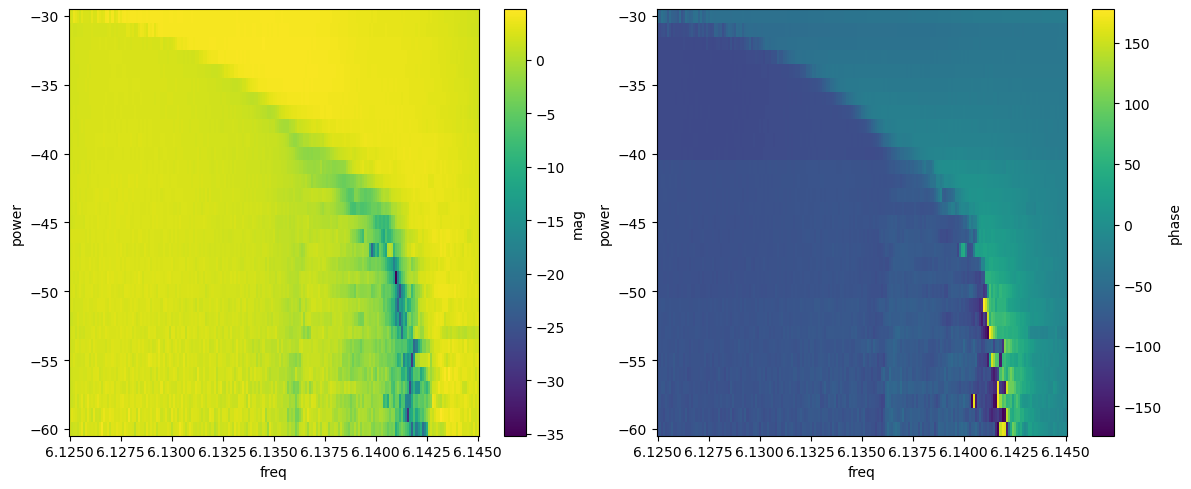

In [117]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
plot3D(
    data_dict=data['two_res'],
    x_key='freq',
    y_key='power',
    z_key='mag',
    ax=ax[0],
    fig=fig
)

plot3D(
    data_dict=data['two_res'],
    x_key='freq',
    y_key='power',
    z_key='phase',
    ax=ax[1],
    fig=fig
)
plt.show()

### Resonator frequency fluctuation

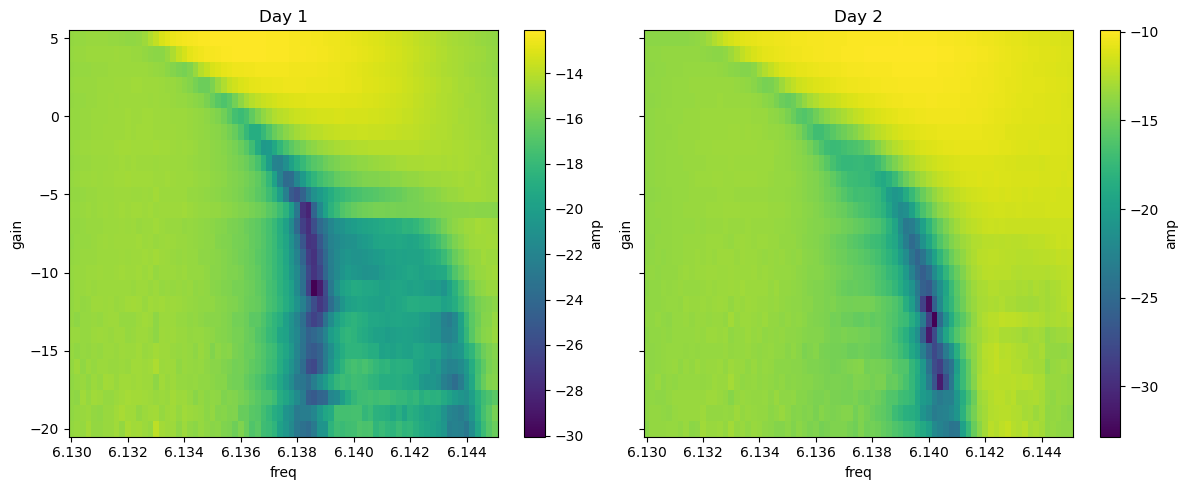

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,5), sharey=True)
ax[0].set_title('Day 1')
ax[1].set_title('Day 2')
plot3D(
    data_dict=data['sts_power_change'],
    x_key='freq',
    y_key='gain',
    z_key='amp',
    ax=ax[0],
    fig=fig
)

plot3D(
    data_dict=data['sts_power_change2'],
    x_key='freq',
    y_key='gain',
    z_key='amp',
    ax=ax[1],
    fig=fig
)
plt.show()

## Single tone spectroscopy vs. flux

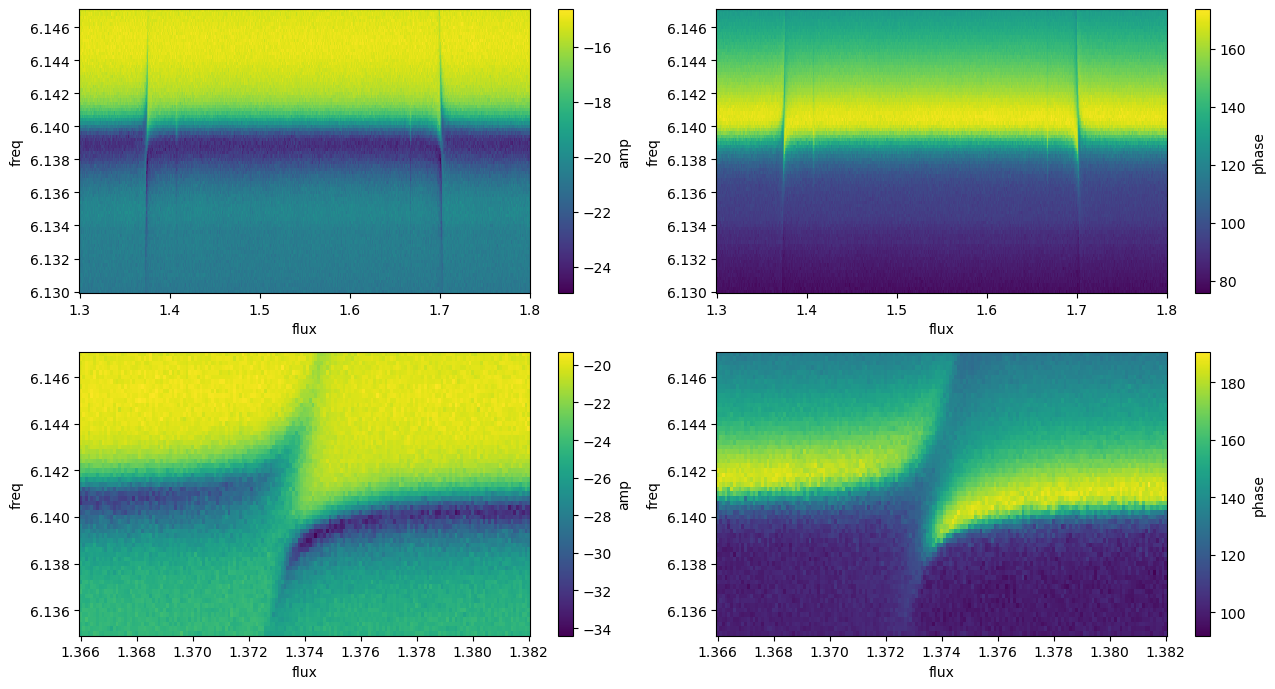

In [144]:
fig, ax = plt.subplots(2,2,figsize=(13,7))
plot3D(
    data_dict=data['sts_flux'],
    x_key='flux',
    y_key='freq',
    z_key='amp',
    ax=ax[0,0],
    fig=fig
)

plot3D(
    data_dict=data['sts_flux'],
    x_key='flux',
    y_key='freq',
    z_key='phase',
    ax=ax[0,1],
    fig=fig
)

plot3D(
    data_dict=data['sts_flux_zoom'],
    x_key='flux',
    y_key='freq',
    z_key='amp',
    ax=ax[1,0],
    fig=fig
)

plot3D(
    data_dict=data['sts_flux_zoom'],
    x_key='flux',
    y_key='freq',
    z_key='phase',
    ax=ax[1,1],
    fig=fig
)   

plt.show()

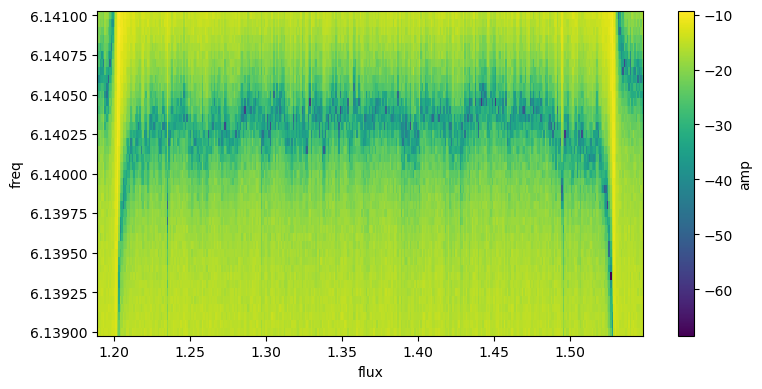

In [143]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
plot3D(
    data_dict=data['res_fluq'],
    x_key='flux',
    y_key='freq',
    z_key='amp',
    ax=ax,
    fig=fig
)
plt.show()

# Two tone spectroscopy

In [33]:
fluxonium = sq.Fluxonium(EJ=10.013,EC=1.588,EL=0.3678, flux=0, cutoff=40)
flux_array1 = np.linspace(-0.5,0,3001)
fluxspec = fluxonium.get_spectrum_vs_paramvals(
    param_name='flux',
    param_vals=flux_array1,
    evals_count=6,
    subtract_ground=False
)

evals_matrix = fluxspec.energy_table
transitions0 = evals_matrix - evals_matrix[:,0].reshape(-1,1)
transitions1 = evals_matrix - evals_matrix[:,1].reshape(-1,1)
transitions2 = evals_matrix - evals_matrix[:,2].reshape(-1,1)

transitions0 = np.delete(transitions0,0,axis=1)
transitions1 = np.delete(transitions1,[0,1],axis=1)

flux_array2 = np.linspace(data['tts_zero']['phi'].min(),data['tts_zero']['phi'].max(),201)
fluxspec2 = fluxonium.get_spectrum_vs_paramvals(
    param_name='flux',
    param_vals=flux_array2,
    evals_count=3,
    subtract_ground=False
)

evals_matrix2 = fluxspec2.energy_table
transitions0_2 = evals_matrix2 - evals_matrix2[:,0].reshape(-1,1)

transitions0_2 = np.delete(transitions0_2,0,axis=1)


Spectral data:   0%|          | 0/3001 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/201 [00:00<?, ?it/s]

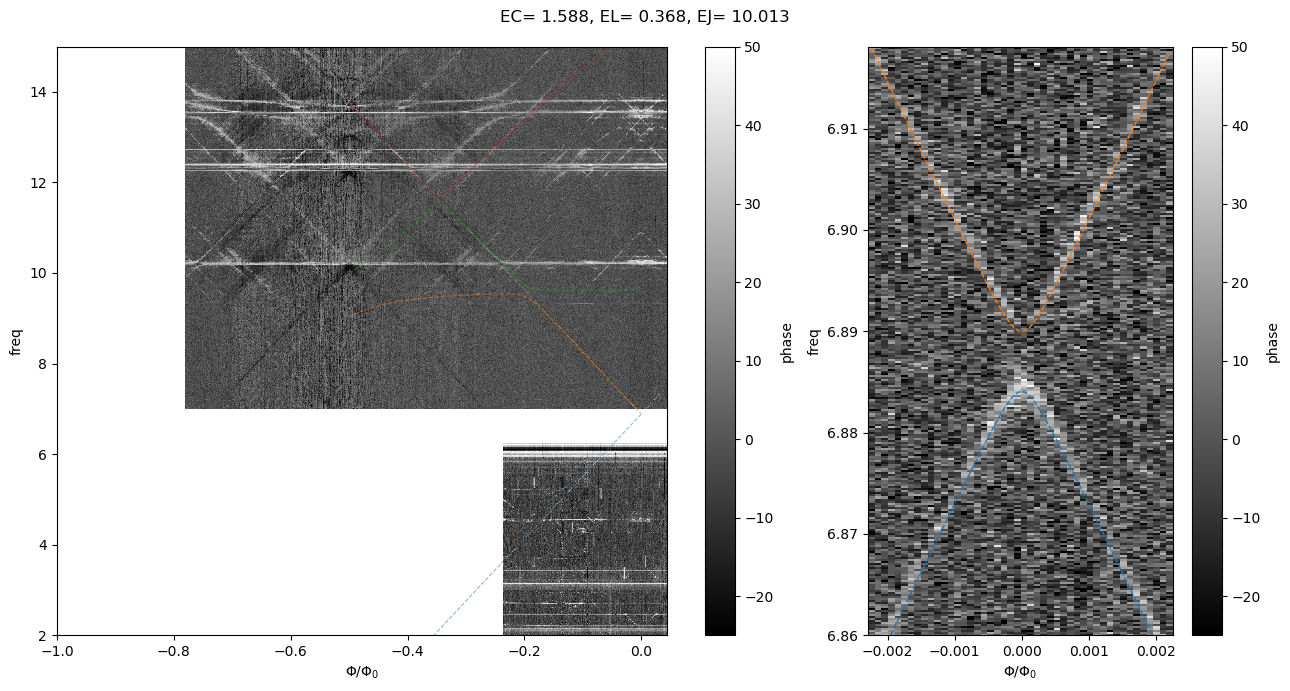

In [152]:
voltage_period = 3.033
zero_flux = 1.3668

tts_dict = {key: data[key] for key in ['tts_upper','tts_lower'] if key in data}

for key in ['tts_upper','tts_lower']:
    tts_dict[key]['phi'] = (tts_dict[key]['flux']-zero_flux)/voltage_period
data['tts_zero']['phi'] = (data['tts_zero']['flux']-zero_flux)/voltage_period
%matplotlib inline
fig,ax = plt.subplots(1,2, figsize=(13,7), gridspec_kw={'width_ratios': [2, 1]})
fig.suptitle(f'EC= {np.round(fluxonium.EC,3)}, EL= {np.round(fluxonium.EL,3)}, EJ= {np.round(fluxonium.EJ,3)}')
plot3Ds(
    data_dicts=tts_dict,
    x_key='phi',
    y_key='freq',
    z_key='phase',
    flatten_vertical=1,
    flatten_horizontal=0,
    ax=ax[0],
    fig=fig,
    vmin=-25,
    vmax=50,
    cmap='gray'
)

ax[0].plot(flux_array1,transitions0, alpha=0.5,linestyle='dashed',linewidth=0.8)
# ax[0].plot(flux_array1,transitions1, alpha=0.5,color='red',linestyle='dashed',linewidth=0.8)
ax[0].set_xlim(left=-1)
ax[0].set_ylim([2,15])

plot3D(
    data_dict=data['tts_zero'],
    x_key='phi',
    y_key='freq',
    z_key='phase',
    ax=ax[1],
    flatten_vertical=1,
    fig=fig,
    vmin=-25,
    vmax=50,
    cmap='gray',
)

ax[1].plot(flux_array2,transitions0_2, alpha=1,linestyle='--',linewidth=1)
ax[1].set_ylim(bottom=6.86)


ax[0].set_xlabel(r'$\Phi/\Phi_0$')
ax[1].set_xlabel(r'$\Phi/\Phi_0$')
plt.tight_layout()
plt.show()

### Double levels

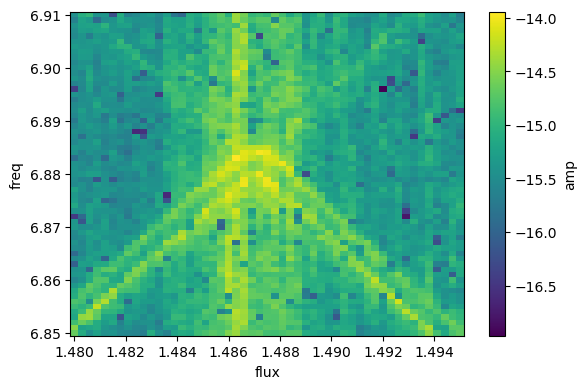

In [138]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
plot3D(
    data_dict=data['tts_double'],
    x_key='flux',
    y_key='freq',
    z_key='amp',
    ax=ax,
    flatten_vertical=0,
    fig=fig
)
plt.show()

### Flux drifting

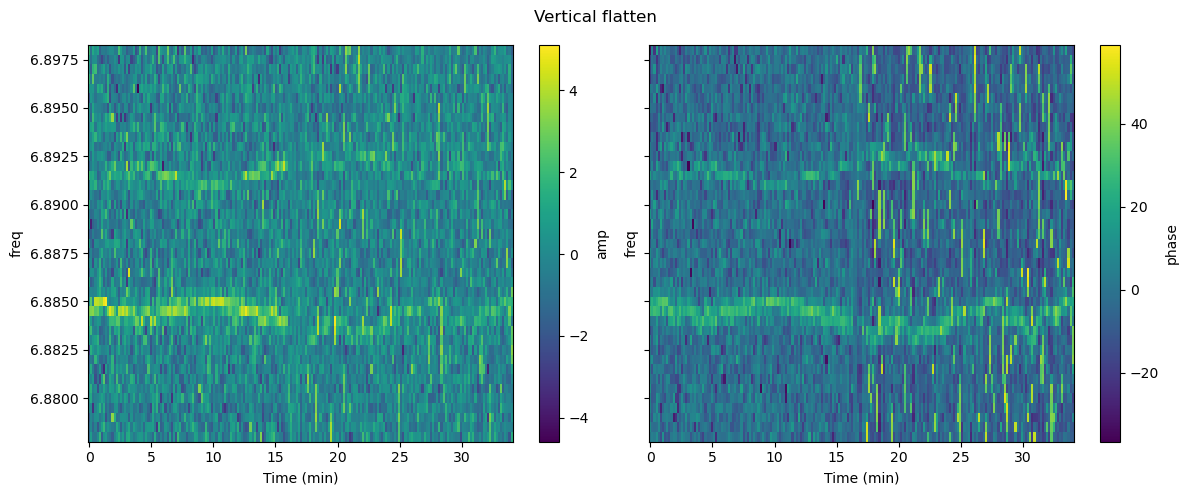

In [11]:
data['flux_drifting']['time'] = np.linspace(0,34,200)

fig, ax = plt.subplots(1,2,figsize=(12,5), sharey=True)
fig.suptitle('Vertical flatten')
plot3D(
    data_dict=data['flux_drifting'],
    x_key='time',
    y_key='freq',
    z_key='amp',
    ax=ax[0],
    flatten_vertical=1,
    fig=fig
)

plot3D(
    data_dict=data['flux_drifting'],
    x_key='time',
    y_key='freq',
    z_key='phase',
    ax=ax[1],
    flatten_vertical=1,
    fig=fig
)
ax[0].set_xlabel('Time (min)')
ax[1].set_xlabel('Time (min)')
plt.show()

# T1

In [92]:
def T1_func(x, A0, A1, T1):
    return A0 + A1 * np.exp(-x / T1)

popt_phase, pcov_phase = curve_fit(T1_func, data['t1']['param']/1e3, data['t1']['phase'], p0=(-49, -5, 100))
popt_amp, pcov_amp = curve_fit(T1_func, data['t1']['param']/1e3, data['t1']['amp'], p0=(-22.6, -0.7, 100))

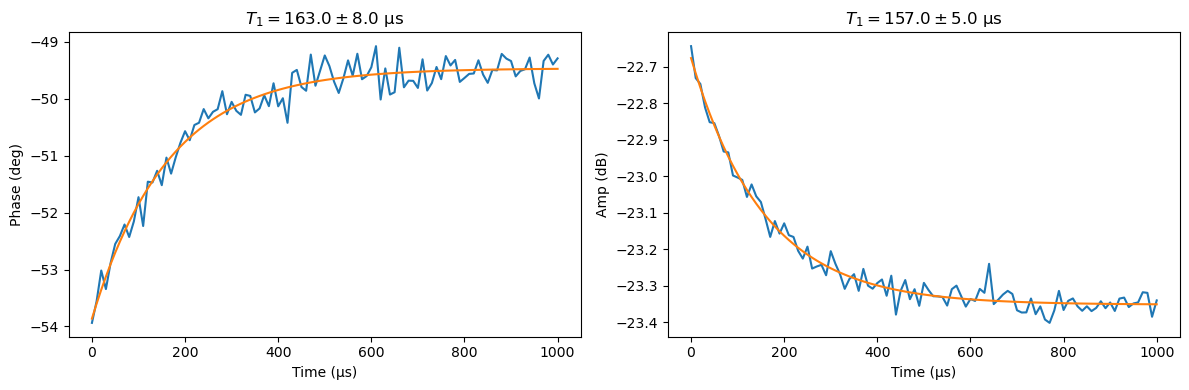

In [93]:
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(data['t1']['param']/1e3, data['t1']['phase'])
ax[1].plot(data['t1']['param']/1e3, data['t1']['amp'])
ax[0].plot(data['t1']['param']/1e3, T1_func(data['t1']['param']/1e3,*popt_phase))
ax[1].plot(data['t1']['param']/1e3, T1_func(data['t1']['param']/1e3,*popt_amp))

ax[0].set_title(rf'$T_1= {np.round(popt_phase[2],0)} \pm {np.round(np.sqrt(pcov_phase[2,2]),0)}$ μs')
ax[1].set_title(rf'$T_1= {np.round(popt_amp[2],0)} \pm {np.round(np.sqrt(pcov_amp[2,2]),0)}$ μs')
ax[0].set_xlabel('Time (μs)')
ax[1].set_xlabel('Time (μs)')
ax[0].set_ylabel('Phase (deg)')
ax[1].set_ylabel('Amp (dB)')
fig.tight_layout()
plt.show()

# Ramsey

In [95]:
def ramsey_func(x, A0, A1, A2, w_qd, T2):
    return A0 + A1 * np.cos(w_qd*x+A2)*np.exp(-x/T2)

popt_T2_phase, pcov_T2_phase = curve_fit(ramsey_func, data['ramsey']['delay_ns']/1e3, data['ramsey']['phase'], p0=(97.5, 8, 0,np.pi, 3))
popt_T2_amp, pcov_T2_amp = curve_fit(ramsey_func, data['ramsey']['delay_ns']/1e3, data['ramsey']['amp'], p0=(-21.75, 0.8, 0,np.pi, 3))

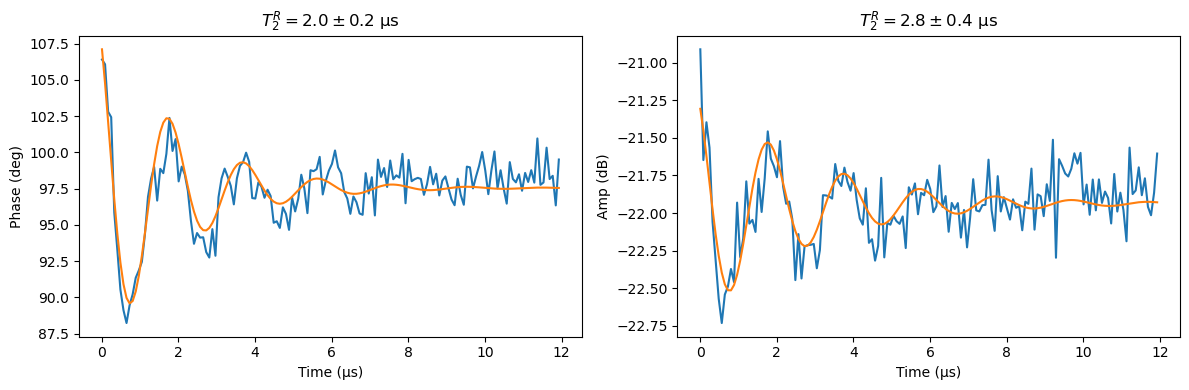

In [97]:
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(data['ramsey']['delay_ns']/1e3, data['ramsey']['phase'])
ax[1].plot(data['ramsey']['delay_ns']/1e3, data['ramsey']['amp'])

ax[0].plot(data['ramsey']['delay_ns']/1e3, ramsey_func(data['ramsey']['delay_ns']/1e3,*popt_T2_phase))
ax[1].plot(data['ramsey']['delay_ns']/1e3, ramsey_func(data['ramsey']['delay_ns']/1e3,*popt_T2_amp))


ax[0].set_title(rf'$T_2^R= {np.round(popt_T2_phase[-1],1)} \pm {np.round(np.sqrt(pcov_T2_phase[-1,-1]),1)}$ μs')
ax[1].set_title(rf'$T_2^R= {np.round(popt_T2_amp[-1],1)} \pm {np.round(np.sqrt(pcov_T2_amp[-1,-1]),1)}$ μs')
ax[0].set_xlabel('Time (μs)')
ax[1].set_xlabel('Time (μs)')
ax[0].set_ylabel('Phase (deg)')
ax[1].set_ylabel('Amp (dB)')
fig.tight_layout()
plt.show()